In [1]:
%matplotlib inline
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from reid import reid

from mvpose.data import cmu_panoptic

root = Settings['CMU']['data_root']
tmp = Settings['tmp']

pprint(Settings['CMU'])
    
FRAME = 2000

panels = Settings['CMU']['panels']
nodes = Settings['CMU']['nodes']

seq_name = Settings['CMU']['seq_name']

# X, Y, Calib = cmu_panoptic.get(root, seq_name, 
#                                 panels, nodes, frame=FRAME)

# heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', 
#                                                         Im, 
#                                                         FRAME, 
#                                                         dir=tmp)

# ==================================
from mvpose import pose
from mvpose.algorithm.settings import get_settings, get_tracking_settings


# --- Things that kinda have to be parametrized ---
candidate_main_name = 'cmu_ms30_candidates_frame'
dict_file = join(tmp, 'scores_cmu_ms30.npy')
params = get_settings(ms_radius=30)
# -------------------------------------------------

params = get_settings(max_epi_distance=20, scale_to_mm=10)

reid_model = reid.ReId()
#reid_model = {}  # we can skip this ONLY if we already calc. reid scores!
tracking_params = get_tracking_settings(params, 
                                        low_spec_mode=True, 
                                        reid_model=reid_model,
                                        personreid_batchsize=2)

# X.shape

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{'data_root': '/storage/DATA/cmu_panoptic',
 'nodes': [1, 15, 3, 13, 8],
 'panels': [1, 6, 14, 18, 5],
 'seq_name': '160422_ultimatum1'}


# Step 1: pre-load pafs and heatmaps
(my laptop 'sucks' so I need to pre-load the pafs and heatmaps)

In [2]:
# def load(FRAMES):
#     for frame in FRAMES:
#         print('handle frame ', frame)
#         Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
#                                 panels, nodes, frame=frame)
#         heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', 
#                                                             Im, 
#                                                             frame, 
#                                                             dir=tmp)
#         del heatmaps
#         del pafs
#         del Im

# def qq():
#     for i in range(2780, 4500, 60):
#         FRAMES = list(range(i, i+60, 30))
#         print('frames:', FRAMES)
#         _start = time()
#         load(FRAMES)
#         _end = time()
#         print('\telapsed', _end - _start)

# qq()  # "memory-efficient" way of loading the data 

# Step 2: generate candidates

In [3]:
# handle frames from 2000 ... 3020

# def execute(FRAME):

#     Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
#                                     panels, 
#                                     nodes, 
#                                     frame=FRAME)

#     print('\nframe:', FRAME)
#     heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', 
#                                                             Im, 
#                                                             FRAME, 
#                                                             dir=tmp)
#     _start = time()
#     detections = pose.estimate_heuristic(
#         Calib, heatmaps, pafs, settings=params, 
#         debug=False, use_greedy=False)
#     _end = time()
#     print('total elapsed:', _end - _start)
    
#     # -- store to file --
#     candidate_name = candidate_main_name + str(FRAME) + ".npy"
#     candidate_name = join(tmp, candidate_name)
#     np.save(candidate_name, detections)
    
#     del heatmaps
#     del pafs
#     del detections

# def run_all():
#     # go to 2500
#     for i in range(2570, 2870, 60):
#         FRAMES = list(range(i, i+60, 30))
#         for f in FRAMES:
#             execute(f)

# run_all()

# Step 3: calculate re-id score

In [4]:
from os.path import isfile
from mvpose.algorithm.track_graph_partitioning import get_bb, distance3d_humans, ValidImageCandidateExtractor
from mvpose.tracking import extend_calibration_to_frames

graph_3d = {}
human_candidates = []
Im = []
for frame in range(2000, 2870, 30):
    if frame % 300 == 0:
        print('frame ', frame)
    candidate_name = candidate_main_name + str(frame) + ".npy"
    candidate_name = join(tmp, candidate_name)
    assert isfile(candidate_name)
    Humans = np.load(candidate_name)
    human_candidates.append(Humans)
    im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                    panels, 
                                    nodes, 
                                    frame=frame)
    
    Im.append(im)
Im = np.array(Im, 'uint8')

print(len(human_candidates))

Calibs = extend_calibration_to_frames([Calib], len(human_candidates))

img_cand = ValidImageCandidateExtractor(Im, human_candidates, Calibs, tracking_params)

# n = len(img_cand.ImgsA)
# print('n', n)
# start = 0
# if isfile(dict_file):
#     start = np.load(dict_file).item()['next_frame']

# print('start:' + str(start) + ' until ' + str(n))
# for frame in range(start, n):
#     if isfile(dict_file):
#         storage = np.load(dict_file).item()
#     else:
#         storage = {}
    
#     if frame % 10 == 0:
#         print('frame %05d/' % (frame+1) + str(n))
#         _start = time()
#     A = img_cand.ImgsA[frame]
#     B = img_cand.ImgsB[frame]
#     score = np.squeeze(reid_model.predict(A, B))
#     #print('storage', storage)
#     #print('score', score)
#     storage[frame] = score
#     storage['next_frame'] = frame + 1
#     np.save(dict_file, storage)
#     if frame % 10 == 0:
#         _end = time()
#         print('\telapsed', _end - _start)
#     del storage
    

29


# Step 4: build graph

In [5]:
from mvpose.algorithm.track_graph_partitioning import generate_graph3d, GraphSolver
from mvpose.algorithm.track_graph_partitioning import construct_query_graph
from mvpose.tracking import extract_tracks

storage = np.load(dict_file).item()

scores = []
pairs = img_cand.pairs
n = len(img_cand.ImgsA)
print(n)

assert(len(pairs) == n)
for frame in range(n):
    scores.append(storage[frame])
assert len(scores) == n


graph_3d = generate_graph3d(scores, pairs)  # t1, pid1, t2, pid2

n_frames_red = len(human_candidates)
graph_partitioning = GraphSolver(graph_3d, 
                                 n_frames_red,
                                 tracking_params.T)


G = construct_query_graph(graph_partitioning, n_frames_red)

tracks = extract_tracks(human_candidates, G)

4560
PPF: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])
[graph partitioning]
	solve graph with 273 edges...


In [10]:
Im.shape

(5, 480, 640, 3)

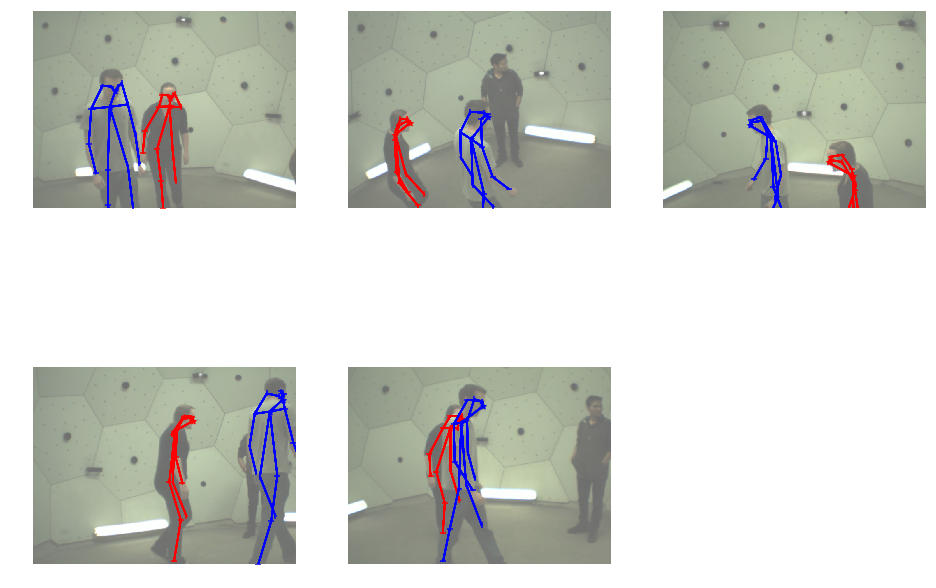

In [16]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

FRAME = 2810
Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
candidate_name = candidate_main_name + str(FRAME) + ".npy"
candidate_name = join(tmp, candidate_name)
Humans = np.load(candidate_name)
_, h, w, _ = Im.shape

#Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,3,1+idx)
    ax.axis('off')
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.show()